In [1]:
from sdm.config import get_db_connection
from text_mining.utils import get_preprocessed_LDA
from text_mining.language import Language
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

/home/krasky/dev/social_data_mining/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /home/krasky/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/krasky/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/krasky/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/krasky/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Task 1.3: LDA (Default)
- Run LDA with learned priors (alpha, eta).
- Choose an appropriate number of topics (K).
- Inspect topics and check if they make sense.

In [2]:
db = get_db_connection(db_path="../../../../data/twitter.db")
df = get_preprocessed_LDA(db, min_chars=1_000)
# df = get_tweet_corpora(db, min_chars=1000)
df.head()

,author_id,text_corpus,account_type,lang,stance,processed_corpus
0,8508262,L'accord de Paris adopté par les 195 pays #COP...,Private individuals,fr,For,paris adopté pays via lemondefr pcanfin ça fai...
1,3297659759,RT @ecocosmopolita: El Acuerdo de París fue me...,Advocacy actors,es,For,ecocosmopolita acuerdo parís mejor esperado le...
2,259352661,RT @RAN: Delegates at #COP21 must work to prot...,Advocacy actors,en,For,ran delegates must work protect indonesia peop...
3,955903212,RT @guardianeco: All the NGO reaction to the d...,Advocacy actors,en,For,guardianeco ngo reaction draft paris climate t...
4,2482232082,".@CFigueres: ""I used to say we must we can w...",Political actors,es,Unclear,cfigueres i used to say we must we can we will...


In [38]:
# K of ~7 seems to get the major langs, higher ones allow more granular topics and languages
# but also seems to create a lot of what seems like nonsense topics (granted most are not in english)
# and I have no idea what words/hashtags/people are in relation to the COP event.
K = 14
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['processed_corpus'])
lda = LatentDirichletAllocation(n_components=K, random_state=42)
lda.fit(X)

LatentDirichletAllocation(n_components=14, random_state=42)

In [40]:
n_top_words = 12
feature_names = vectorizer.get_feature_names_out()

# Display the topics
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx}:")
    print("|".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Topic #0:
climat|paris|laurentfabius|direct|accord|climatique|texte|plus|royalsegolene|fhollande|pays|monde

Topic #1:
acuerdo|parís|climático|cambioclimático|ambassades|cambio|clima|el|cumbre|países|cmnucc|hoy

Topic #2:
sassoufit|rfi|goparis|comprendre|dossier|pourlascience|climatechange|thecvf|dernier|québec|shrinking|tout

Topic #3:
emblème|découvrez|vidéo|bravo|partagez|créer|contribué|façonne|retweetez|découvrir|prêt|dès

Topic #4:
afp|elisedepenoux|climat|paris|accord|infloodwetrust|pays|climatique|projet|gt|amp|laurentfabius

Topic #5:
cdnpoli|design|climatechange|green|climatehealth|health|blog|science|eco|fresh|amp|paddletoparis

Topic #6:
pour|du|sur|aux|au|une|est|si|nous|opchemtrails|enfants|dans

Topic #7:
sassoui|nrcg|sassou|denis|nguesso|du|planète|est|congo|bassin|brazzaville|climatique

Topic #8:
climate|amp|paris|text|new|agreement|climatechange|countries|event|africa|today|says

Topic #9:
climate|paris|climatechange|amp|change|world|unfccc|action|agreement|today|glo

In [11]:
# Like elbow method in K-means Data Mining:
perplexities = []
for k in range(2, 80, 2):
    lda = LatentDirichletAllocation(n_components=k, random_state=42, n_jobs=-1)
    lda.fit(X)
    perplexities.append({"perplexity":lda.perplexity(X), "K": k})


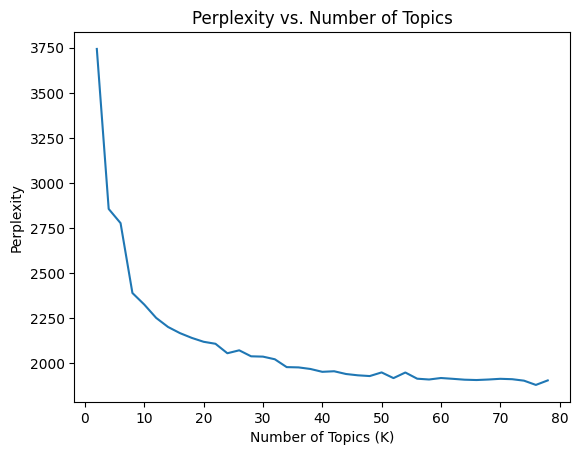

In [13]:
sns.lineplot(data=pd.DataFrame(perplexities), x="K", y="perplexity")
plt.xlabel("Number of Topics (K)")
plt.ylabel("Perplexity")
plt.title("Perplexity vs. Number of Topics")
plt.show()